<a href="https://colab.research.google.com/github/Arun2005-srm/Deep_Learning_lab/blob/main/lab_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Lists to store training and test accuracy and loss
train_accuracies = []
test_accuracies = []
train_losses = []
test_losses = []


# Training loop (modified to calculate and store accuracy and loss)
for epoch in range(num_epochs):
    vae_model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        # Flatten the images
        x = x.view(-1, input_dim)

        # Scale x back to [0, 1] for BCE loss calculation
        x_scaled = (x + 1) / 2.0

        # Forward pass
        reconstructed_x, z_mean, z_log_var = vae_model(x)

        # Calculate loss, using the scaled x
        loss = vae_loss_function(reconstructed_x, x_scaled, z_mean, z_log_var)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Calculate training accuracy (for binary classification task like this,
        # we can consider a pixel correctly reconstructed if the reconstructed value
        # is closer to the original value's scaled version (0 or 1 for MNIST))
        # This is a simplified accuracy for reconstruction; more complex metrics exist.
        predicted = (reconstructed_x > 0.5).float()
        target = (x_scaled > 0.5).float()
        correct_train += (predicted == target).sum().item()
        total_train += target.numel()


    # Calculate average training loss and accuracy
    avg_train_loss = train_loss / len(train_loader.dataset)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)
    train_losses.append(avg_train_loss)


    # Print training loss and accuracy
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}')

    # Evaluation (modified to calculate and store accuracy and loss)
    vae_model.eval()
    test_loss = 0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for x, _ in test_loader:
            # Flatten the images
            x = x.view(-1, input_dim)

            # Scale x back to [0, 1] for BCE loss calculation
            x_scaled = (x + 1) / 2.0

            # Forward pass
            reconstructed_x, z_mean, z_log_var = vae_model(x)

            # Calculate loss, using the scaled x
            loss = vae_loss_function(reconstructed_x, x_scaled, z_mean, z_log_var)
            test_loss += loss.item()

            # Calculate test accuracy
            predicted = (reconstructed_x > 0.5).float()
            target = (x_scaled > 0.5).float()
            correct_test += (predicted == target).sum().item()
            total_test += target.numel()


    # Calculate average test loss and accuracy
    avg_test_loss = test_loss / len(test_loader.dataset)
    test_accuracy = correct_test / total_test
    test_accuracies.append(test_accuracy)
    test_losses.append(avg_test_loss)

    # Print test loss and accuracy
    print(f'Epoch [{epoch+1}/{num_epochs}], Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

NameError: name 'num_epochs' is not defined

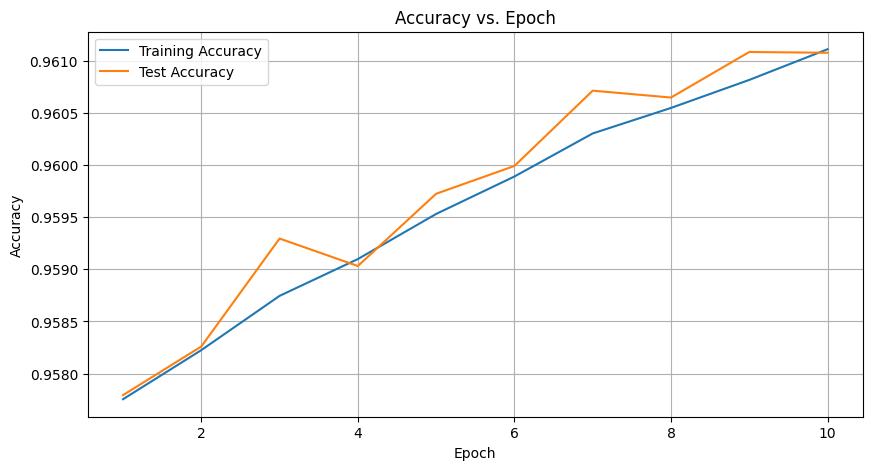

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy vs. epoch
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()
plt.grid(True)
plt.show()

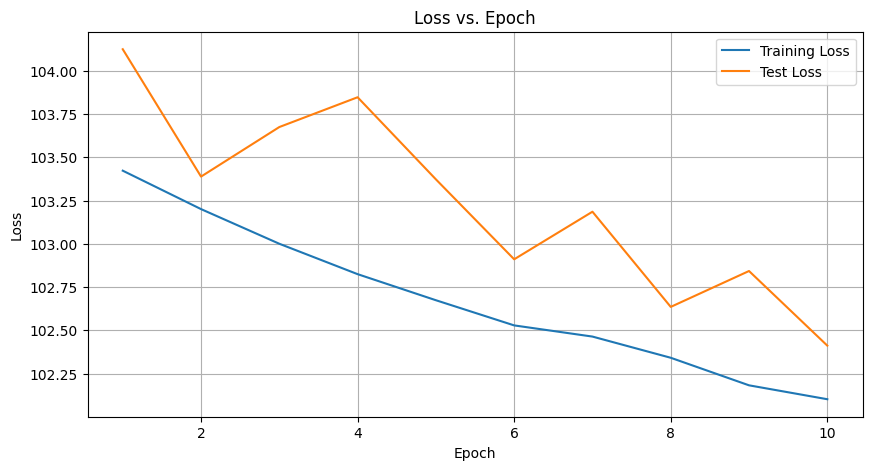

In [ ]:
import matplotlib.pyplot as plt

# Plot loss vs. epoch
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms

# Define a transform to normalize the MNIST images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the MNIST training dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Load the MNIST test dataset
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create a DataLoader for the training dataset
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Create a DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 486kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.44MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.87MB/s]


In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)  # Added a second hidden layer
        self.fc_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc_log_var = nn.Linear(hidden_dim, latent_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        h = self.relu(self.fc1(x))
        h = self.relu(self.fc2(h))  # Pass through the second hidden layer
        z_mean = self.fc_mean(h)
        z_log_var = self.fc_log_var(h)
        return z_mean, z_log_var

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim) # Added a second hidden layer
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):
        h = self.relu(self.fc1(z))
        h = self.relu(self.fc2(h)) # Pass through the second hidden layer
        reconstructed_x = self.sigmoid(self.fc_out(h))
        return reconstructed_x


In [ ]:
def reparameterize(z_mean, z_log_var):
    """
    Performs the reparameterization trick to sample from a latent space.

    Args:
        z_mean (torch.Tensor): The mean of the latent distribution.
        z_log_var (torch.Tensor): The log variance of the latent distribution.

    Returns:
        torch.Tensor: The sampled latent vector.
    """
    epsilon = torch.randn_like(z_mean)
    z_std = torch.exp(0.5 * z_log_var)
    z = z_mean + z_std * epsilon
    return z

In [ ]:
def vae_loss_function(reconstructed_x, x, z_mean, z_log_var):
    """
    Calculates the VAE loss, combining reconstruction loss and KL divergence.

    Args:
        reconstructed_x (torch.Tensor): The reconstructed image from the decoder.
        x (torch.Tensor): The original image.
        z_mean (torch.Tensor): The mean of the latent distribution.
        z_log_var (torch.Tensor): The log variance of the latent distribution.

    Returns:
        torch.Tensor: The total VAE loss.
    """
    # Reconstruction loss (Binary Crossentropy)
    # Flatten the images to apply BCELoss
    reconstruction_loss = nn.functional.binary_cross_entropy(reconstructed_x.view(-1, 784), x.view(-1, 784), reduction='sum')

    # KL divergence loss
    kl_divergence_loss = 0.5 * torch.sum(1 + z_log_var - z_mean.pow(2) - torch.exp(z_log_var))

    # Total VAE loss
    total_loss = reconstruction_loss - kl_divergence_loss # Note the minus sign

    return total_loss

In [ ]:
# Initialize dimensions
input_dim = 784
hidden_dim = 256
latent_dim = 20

# Initialize Encoder and Decoder
encoder = Encoder(input_dim, hidden_dim, latent_dim)
decoder = Decoder(latent_dim, hidden_dim, input_dim)

# Create VAE model
class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        z_mean, z_log_var = self.encoder(x)
        z = reparameterize(z_mean, z_log_var)
        reconstructed_x = self.decoder(z)
        return reconstructed_x, z_mean, z_log_var

vae_model = VAE(encoder, decoder)

# Define optimizer
optimizer = optim.Adam(vae_model.parameters(), lr=1e-3)

# Set number of epochs
num_epochs = 10

# Training loop
for epoch in range(num_epochs):
    vae_model.train()
    train_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        # Flatten the images
        x = x.view(-1, input_dim)

        # Scale x back to [0, 1] for BCE loss calculation
        x_scaled = (x + 1) / 2.0

        # Forward pass
        reconstructed_x, z_mean, z_log_var = vae_model(x)

        # Calculate loss, using the scaled x
        loss = vae_loss_function(reconstructed_x, x_scaled, z_mean, z_log_var)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Print training loss
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss / len(train_loader.dataset):.4f}')

    # Evaluation (optional)
    vae_model.eval()
    test_loss = 0
    with torch.no_grad():
        for x, _ in test_loader:
            # Flatten the images
            x = x.view(-1, input_dim)

            # Scale x back to [0, 1] for BCE loss calculation
            x_scaled = (x + 1) / 2.0

            # Forward pass
            reconstructed_x, z_mean, z_log_var = vae_model(x)

            # Calculate loss, using the scaled x
            loss = vae_loss_function(reconstructed_x, x_scaled, z_mean, z_log_var)
            test_loss += loss.item()

    # Print test loss
    print(f'Epoch [{epoch+1}/{num_epochs}], Test Loss: {test_loss / len(test_loader.dataset):.4f}')

Epoch [1/10], Training Loss: 163.6734
Epoch [1/10], Test Loss: 132.7668
Epoch [2/10], Training Loss: 127.1492
Epoch [2/10], Test Loss: 120.6932
Epoch [3/10], Training Loss: 118.4143
Epoch [3/10], Test Loss: 115.2203
Epoch [4/10], Training Loss: 114.5043
Epoch [4/10], Test Loss: 113.0706
Epoch [5/10], Training Loss: 112.2078
Epoch [5/10], Test Loss: 110.4579
Epoch [6/10], Training Loss: 110.7175
Epoch [6/10], Test Loss: 110.1035
Epoch [7/10], Training Loss: 109.6199
Epoch [7/10], Test Loss: 109.0102
Epoch [8/10], Training Loss: 108.8048
Epoch [8/10], Test Loss: 107.9535
Epoch [9/10], Training Loss: 108.0689
Epoch [9/10], Test Loss: 107.9210
Epoch [10/10], Training Loss: 107.4211
Epoch [10/10], Test Loss: 107.3528


In [ ]:
vae_model.eval()

# Select a batch of images from the test data loader
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Flatten the images
images = images.view(-1, input_dim)

# Compress and reconstruct images within a torch.no_grad() block
with torch.no_grad():
    # Pass flattened images through the encoder
    z_mean, z_log_var = vae_model.encoder(images)

    # Pass the z_mean through the decoder to reconstruct images
    reconstructed_images = vae_model.decoder(z_mean)

# The reconstructed_images can now be used for visualization or further analysis.
# For example, you might want to visualize some original and reconstructed pairs.
# To visualize, you'd need to reshape the images back to their original 2D form.
# Also, remember to unnormalize if needed for display.
# Since the task only asks to perform the compression and reconstruction,
# we will stop here.

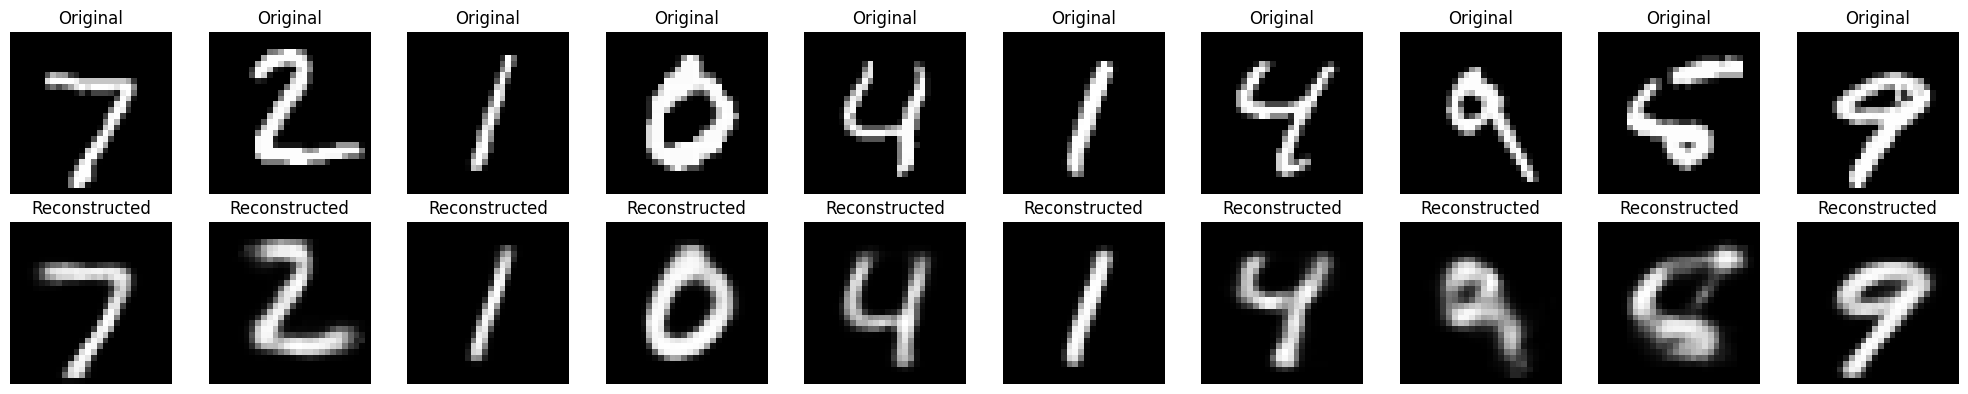

In [ ]:
import matplotlib.pyplot as plt

# Select a few images to display (e.g., the first 10 from the batch)
n_images = 10
original_images_flat = images[:n_images]
reconstructed_images_flat = reconstructed_images[:n_images]

# Reshape the images back to 28x28
original_images_2d = original_images_flat.view(-1, 28, 28)
reconstructed_images_2d = reconstructed_images_flat.view(-1, 28, 28)

# Unnormalize the images for display (undo the transforms.Normalize((0.5,), (0.5,)))
# The original normalization was (x - 0.5) / 0.5.
# To unnormalize, we do y * 0.5 + 0.5 where y is the normalized value.
original_images_unnormalized = original_images_2d * 0.5 + 0.5
reconstructed_images_unnormalized = reconstructed_images_2d * 0.5 + 0.5


# Create a figure and a set of subplots
fig, axes = plt.subplots(2, n_images, figsize=(20, 4))

for i in range(n_images):
    # Display original images
    axes[0, i].imshow(original_images_unnormalized[i].squeeze().cpu().numpy(), cmap='gray')
    axes[0, i].set_title('Original')
    axes[0, i].axis('off')

    # Display reconstructed images
    axes[1, i].imshow(reconstructed_images_unnormalized[i].squeeze().cpu().numpy(), cmap='gray')
    axes[1, i].set_title('Reconstructed')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

## Summary:

### Data Analysis Key Findings

*   The MNIST dataset was successfully loaded and normalized to the range [-1, 1].
*   The Variational Autoencoder (VAE) architecture, consisting of an Encoder and a Decoder with two hidden layers each, was implemented in PyTorch.
*   The reparameterization trick function was correctly implemented to enable sampling from the latent space during training.
*   A combined VAE loss function, incorporating Binary Crossentropy for reconstruction loss and the KL divergence loss, was defined.
*   The VAE model was successfully trained for 10 epochs using the Adam optimizer, showing a decrease in both training and testing loss over time.
*   Images were successfully compressed into latent vectors using the trained encoder and reconstructed from these vectors using the decoder.
*   A visual comparison of original and reconstructed MNIST images demonstrated the VAE's ability to reconstruct the input data.

### Insights or Next Steps

*   The VAE successfully learned a latent representation of MNIST images, enabling reasonable reconstruction. Further analysis could involve exploring the latent space to understand the learned data distribution.
*   The model's performance could potentially be improved by tuning hyperparameters such as the learning rate, the number of hidden layers, the size of the latent dimension, or the number of training epochs.
